# DAMASK postproc example
When matflow goes arwy, your huge CP simulation has finished running, but you have no simulation results in `workflow.hdf5`, do not fear!
You shouldn't have to rerun entire simulations just because you mispelt `volume_data` as `vulome_data`!
This notebook is intended as an example of post-processing DAMASK simualtion data directly from the DAMASK simulation `geom_load.hdf5` file.

More detail about the functions and methods used can be found here:https://damask.mpie.de/documentation/processing_tools/post-processing.html

First, import required libraries, including some useful functions found in this repository...

In [1]:
# Firstly, load in the required python libraries and functions:
# libraries and functions from the web:
import numpy as np
import damask
import matplotlib.pyplot as plt

# libraries and functions local to this repository:
from utils import import_diff_params
from lattice_strain import VE_phase_mask
from lattice_strain import lattice_strain
from plotting import plot_latticestrain
from plotting import plot_truestrain_peakint
from plotting import plot_lattice_strain_dist_inc

%matplotlib inline

Next, define the path to the workflow in which your simulation is contained.

Then, add on to this path the location of the `geom_load.hdf5` file.

Finally, use the `Result` function from damask on the file to save all of it's attributes to a python variable.

In [2]:
# define path to completed DAMASK geom_load.hdf5 file...
workflow_dir = "/mnt/iusers01/jf01/y15576gb/\
postprocessing/flowstress_CRSS_sensitivity_study/\
034_Ti64_TIFUN-T4_TD_910C_VE64x_elongated_Xprism_TensionY_1mms-1_CRSSratio_100beta_200basal_200prism_400pyram_aNsl_5_bNsl_5_2023-08-25-134000/"

# use damask result file to import the result.hdf5 file into jupyter as a variable...
geom_load_path = workflow_dir+"task_2_simulate_volume_element_loading/geom_load.hdf5"

results = damask.Result(geom_load_path)

From here on where postprocessing with matflow or DAMASK is different.

The initially outputted `geom_load.hdf5` file doesn't contain cauchy stress or strain.
So we need to use the damask function `add_...()` to calculate these attributes and add them to the `geom_load.hdf5` file.

Next, we can save the desired attribute to a python variable using the `.get()` damask function.
This returns a dict of the attribute for all increments and phases.
Therefore to get volume data will be a little more tricky...

In [ ]:

# results.add_stress_cauchy
# results.add_strain()

In [3]:

cauchy_stress = results.get('sigma')
epsilon = results.get('epsilon_V^0(F)')

 ██████████████████████████████████████████████████ 100% ETA 0:00:00
 ██████████████████████████████████████████████████ 100% ETA 0:00:00


In [80]:
# Define changes in increment timestep throughout simulation
final_inc = int(results.increments[-1][-4:])
starts = [0, 100]
stops = [100, final_inc]
steps = [100, 100]

reduced_incs = []
for stage, step in enumerate(steps):
    print(f"Stage : {stage}\tStart : inc{starts[stage]}\tStop : inc{stops[stage]}\tStep : {step}")
    # reduce output increment list to that desired
    for increment in range(starts[stage], stops[stage], step):
        reduced_incs.append(f"increment_{increment}")
print(f"Total incs to post process: {len(new_inc_list)}")

Stage : 0	Start : inc0	Stop : inc100	Step : 100
Stage : 1	Start : inc100	Stop : inc5030	Step : 100
Total incs to post process: 51


Lets first double check the total increments, loadcase, and strain rate of the model...

From the dictionaries we aquire in the previous step, we can extract the data and plot it:


Axis : X
	phase : Ti_alpha
	phase_strain : (51,)
	phase_stress : (51,)
	phase : Ti_beta
	phase_strain : (51,)
	phase_stress : (51,)

Axis : Y
	phase : Ti_alpha
	phase_strain : (51,)
	phase_stress : (51,)
	phase : Ti_beta
	phase_strain : (51,)
	phase_stress : (51,)

Axis : Z
	phase : Ti_alpha
	phase_strain : (51,)
	phase_stress : (51,)
	phase : Ti_beta
	phase_strain : (51,)
	phase_stress : (51,)


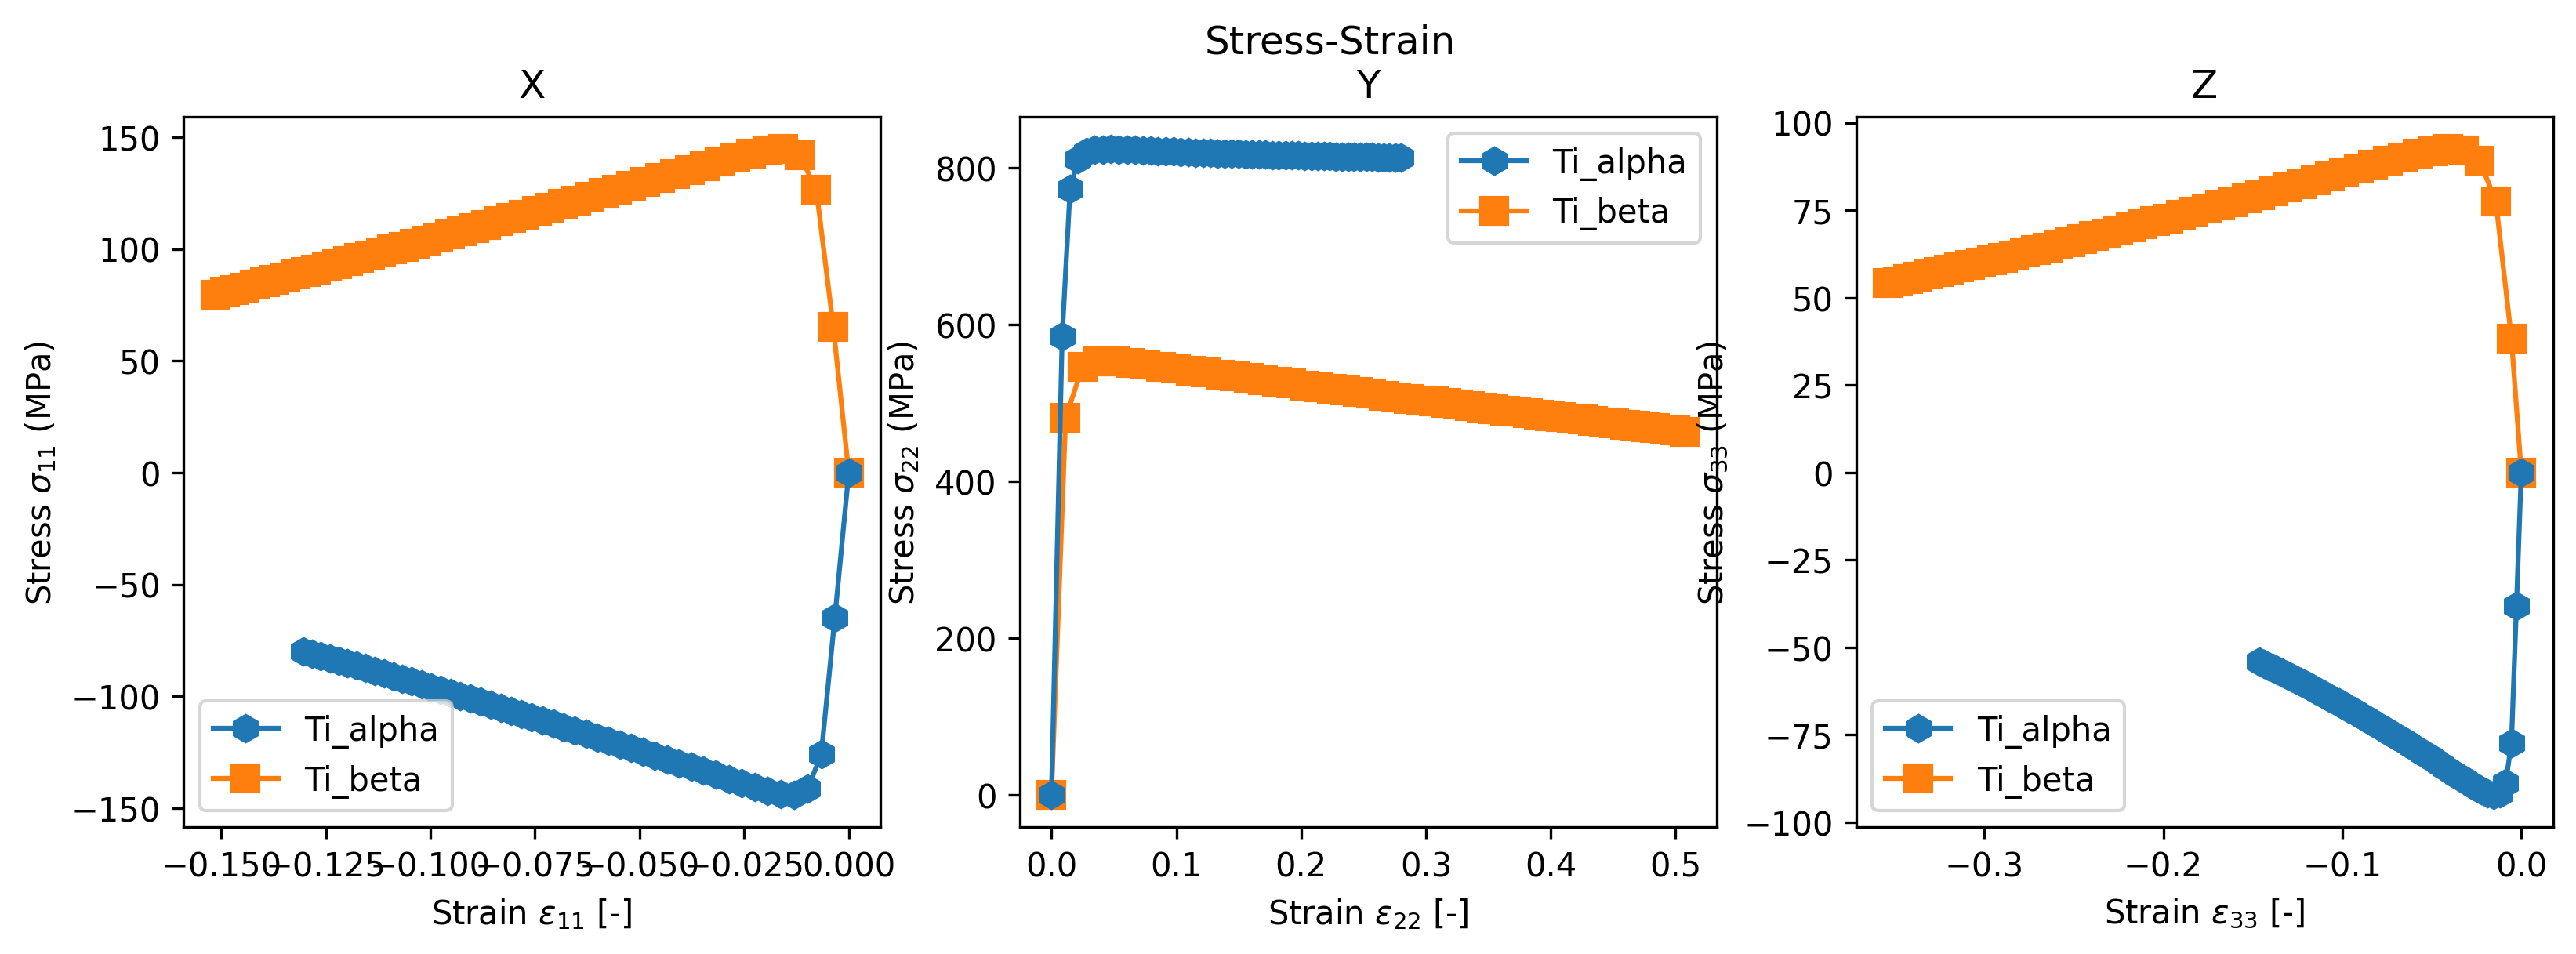

In [86]:

fig, axs = plt.subplots(1,3, figsize=(13, 4), dpi=300, facecolor='w')
fig.suptitle('Stress-Strain')

stress_strain = {}

for i, axis in enumerate(["X", "Y", "Z"]): # loop over axes directions
    print(f"\nAxis : {axis}")
    stress_strain[axis] = {}
    vol_stress = np.ndarray(shape=0)
    vol_strain = np.ndarray(shape=0)
    
#     # some method for averaging data over all phases for each increment.
#     for increment, phase in epsilon.items():
#         vol_stress = np.append(vol_stress, epsilon[increment])/len(epsilon[increment][phase]))
    
    for phase in results.phases:
        print(f"\tphase : {phase}")
        phase_stress = np.ndarray(shape=0)
        phase_strain = np.ndarray(shape=0)
        
        for increment in reduced_incs:
            phase_stress = np.append(phase_stress, cauchy_stress[increment][phase][:,i,i].mean(axis=0))
            phase_strain = np.append(phase_strain, epsilon[increment][phase][:,i,i].mean(axis=0))
        print(f"\tphase_strain : {phase_strain.shape}")
        print(f"\tphase_stress : {phase_stress.shape}")
            
        stress_strain[axis][f'{phase}_stress'] = phase_stress/1e6 # MPa
        stress_strain[axis][f'{phase}_strain'] = phase_strain

        if phase == "Ti_alpha":
            axs[i].plot(stress_strain[axis][f'{phase}_strain'], stress_strain[axis][f'{phase}_stress'],
                        marker='h', markersize=8, color="tab:blue",
                        label = phase, zorder=1)
        if phase == "Ti_beta":
            axs[i].plot(stress_strain[axis][f'{phase}_strain'], stress_strain[axis][f'{phase}_stress'],
                        marker='s', markersize=8, color="tab:orange",
                        label = phase, zorder=0)

#     axs[i].plot(stress_strain[axis]['strain'], abs(stress_strain[axis]['stress']),
#                 linestyle="solid", marker='None', color="k",
#                 label = "Volume")

    axs[i].title.set_text(f"{axis}")
    axs[i].set_facecolor("white")
    axs[i].set_xlabel(f"Strain $\epsilon_{{{str(i+1)}{str(i+1)}}}$ [-]")
    axs[i].set_ylabel(f"Stress $\sigma_{{{str(i+1)}{str(i+1)}}}$ (MPa)")
    axs[i].legend()

# save stress_strain dict as .pkl file to avoid reloading workflow.hdf5 file:
# pickle.dump(stress_strain, open(workflow_dir+'stress_strain.pkl', 'wb'))